# Some ideas for spectral MC Simulations

In [1]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

import luxpy as lx
import numpy as np
from matplotlib import pyplot
import seaborn as sns
import pandas as pd

# temp import only
from empir19nrm02.Jupyter.jhelp import strd, label_font_size, plot_cmf2, save_fig, get_target, label_management, \
    quantil, display_responsivity, get_fig_file_name

%run -i jhelp

%matplotlib inline


from empir19nrm02.spectral import McSpectrumX, generate_FourierMC0
from empir19nrm02.tools import plotHistScales, plotHistScalesWl, plotHistScalesValue, \
    array2analyse, analyse_stat, seaborn_plot_basedata, seaborn_plot_result, sumMC, sumMCV
from empir19nrm02.f1prime import py_f1PrimeG,  py_f1PrimeGlx

from empir19nrm02 import _SPD, _RES

print('Version of luxpy:', lx.__version__)
out_dir = 'MCMet'


Version of luxpy: v1.9.6


# Parameter for the simulation
#### Let's modify some standard data first and caculate some integrated valeus like $f_{1}^{'}$ and Yxy tristimulus values

In [2]:
strWeighting = 'A'
strObserver = '1931_2'
# let's use the V(Lambda) Function (0 ... X, 1...Y, 2...Z)
iObserverOffset = 1
wlResolution = 5
wlStart = 380
wlStop = 780
trials = 1000

bIdeal = False
bSimDetector = False    # True use RES for Simulation, False use SPD for simulation
selected_detector = 73
selected_SPD = 2 # 1=NLA, 2=L41

def plotCorrelation( image, wl_scale, name):
    fig, ax1 = pyplot.subplots(figsize=(7,7))
    im1 = ax1.imshow(image,
                 extent=[wl_scale[0], wl_scale[-1], wl_scale[-1], wl_scale[0]],
                 cmap="jet", interpolation="nearest")
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im1, cax=cax, orientation='vertical')
    ax1.set_title(name)
    ax1.set_xlabel('$\lambda$ / nm', fontsize=label_font_size)
    ax1.set_ylabel('$\lambda$ / nm', fontsize=label_font_size)

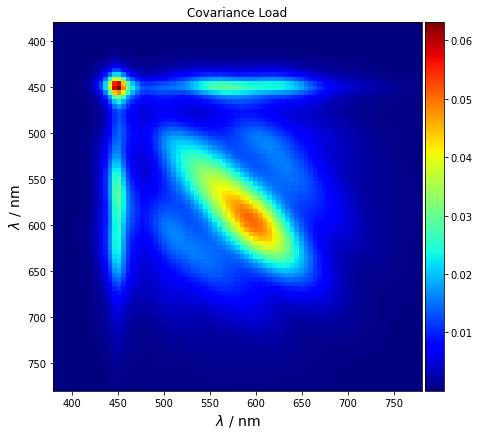

In [3]:
cov_image_load = np.loadtxt(get_fig_file_name(dir=out_dir, filename='MC_value_All_cov', table=True), delimiter=';')

wl_scale = np.arange(wlStart,wlStop+1,wlResolution)
plotCorrelation( cov_image_load, wl_scale, 'Covariance Load')

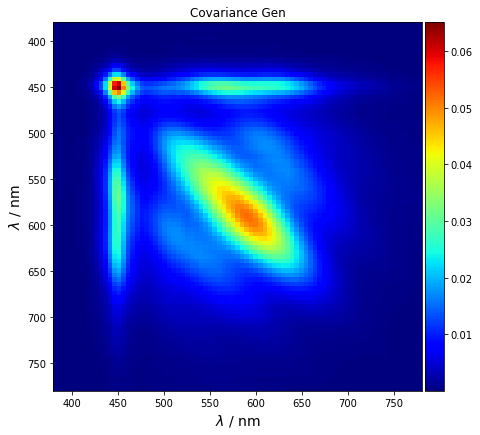

In [4]:
mean_data = np.zeros((len(wl_scale)))
rand_data = np.random.default_rng().multivariate_normal(mean_data, cov_image_load, trials)
cov_data = np.cov( rand_data.T)
plotCorrelation( cov_data, wl_scale, 'Covariance Gen')

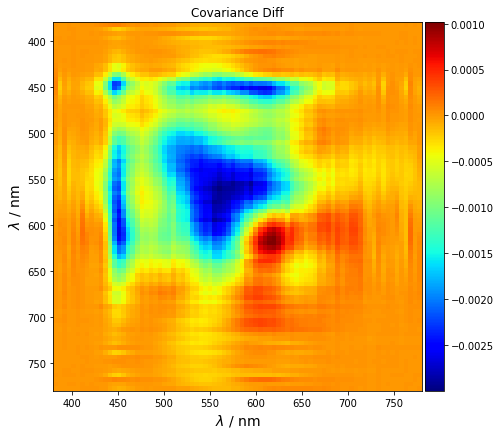

In [5]:
plotCorrelation( cov_image_load-cov_data, wl_scale, 'Covariance Diff')

In [6]:
w,v=np.linalg.eig(cov_image_load)
w;v

array([[-1.3633e-03, -5.8495e-04, 1.3172e-03, ..., -3.3703e-03,
        4.6051e-03, -2.2202e-02],
       [-1.5283e-03, -4.0460e-04, 2.2142e-03, ..., -8.6705e-03,
        -9.1868e-02, -3.9507e-02],
       [-7.6998e-04, -1.0523e-03, 1.3373e-03, ..., 1.1251e-01,
        -2.2164e-01, -1.0217e-01],
       ...,
       [-4.3063e-03, -5.9702e-04, 2.8990e-04, ..., -1.6378e-02,
        1.8153e-01, -5.4813e-03],
       [-4.0395e-03, -1.5055e-03, 1.3637e-03, ..., -9.5398e-02,
        2.0779e-01, 5.6849e-02],
       [-2.9834e-03, -1.1741e-04, 3.3922e-04, ..., 1.4053e-01,
        -6.1349e-02, -1.7315e-02]])

# MC Simulation
Define some data to work with (let's start with the $V(\lambda)$ function)


In [7]:
lxCmf = lx._CMF['1931_2']
lxCmfInterpolate = lx.cie_interp(lxCmf['bar'], \
    wl_new = np.arange(wlStart,wlStop+1,wlResolution),\
    kind = 'S')
res = len(lxCmfInterpolate[0])

# Data storage
Take a nominal wavelength scale and the ideal detector/SPD and sore all together into a class instance SPD from luxpy

In [8]:
if bSimDetector:
    if bIdeal:
        wl=lxCmfInterpolate[0].reshape(1,res)
        value=lxCmfInterpolate[2].reshape(1,res)
        spd_init = np.r_[wl, value]
    else:
        from empir19nrm02 import _RES
        wl= _RES['VLDetectors']['S']['data'][0].copy()
        value= _RES['VLDetectors']['S']['data'][selected_detector].copy()
        res_tmp = wl.shape[0]
        wl=wl.reshape(1,res_tmp)
        value=value.reshape(1,res_tmp)
        spd_org = np.r_[wl, value]
        spd_init = lx.cie_interp(spd_org, \
            wl_new = np.arange(wlStart,wlStop+1,wlResolution),\
            kind = 'S')
else:
    if bIdeal:
        lxSpdInterpolate = lx.cie_interp(lx._CIE_ILLUMINANTS['LED_L41'], \
            wl_new = np.arange(wlStart,wlStop+1,wlResolution),\
            kind = 'S')
        wl=lxSpdInterpolate[0].reshape(1,res)
        value=lxSpdInterpolate[1].reshape(1,res)
        spd_init = np.r_[wl, value]
    else:
        from empir19nrm02 import _SPD
        wl= _SPD['PHOTOLED']['S']['data'][0].copy()
        value= _SPD['PHOTOLED']['S']['data'][selected_SPD].copy()
        res_tmp = wl.shape[0]
        wl=wl.reshape(1,res_tmp)
        value=value.reshape(1,res_tmp)
        spd_org = np.r_[wl, value]
        spd_init = lx.cie_interp(spd_org, \
            wl_new = np.arange(wlStart,wlStop+1,wlResolution),\
            kind = 'S')


# Scale to reference?
True    all graphs will be shown as difference to the reference
False   all graphs will be shown as they are (without referencing the data)

In [9]:
scale_to_reference = True

# MC Steps?
All MC simulation include several steps (one step for every parameter in the model). The useage of these steps can be
selected here.

At the end, all selected parameters needs to be switched on together for the combined uncertainty.

In [10]:
mc_enable = { 'nothing': True,
              'wl_noise_nc': True,
              'wl_noise_c': True,
              'wl_fourier_noise':True,
              'value_noise_nc': True,
              'value_noise_c': True,
              'value_fourier_noise':True,
              'all': True,
              'cov': False,
              }

# Running the MC simulation

In [11]:
class MCSpectrumColorResults(object):
    class mc_budget_table_color:
        name = 'empty'
        mean = 0.0
        stddev = 0.0
        nb = 0
        dist = ''
        Y = 0
        x = 0
        y = 0
        cct = 0
        sY = 0
        sx = 0
        sy = 0
        scct = 0
    def __init__(self, trials=1000):
        self.trials = trials
        # Array containing the integral results (here Yxy and CCT for a more-dimensional  output)
        result = np.zeros( (4, trials))

class MCSpectrumf1Results(object):
    class mc_budget_table_f1:
        name = 'empty'
        mean = 0.0
        stddev = 0.0
        nb = 0
        dist = ''
        f1p=0
        f1pE=0
        f1pL=0
        f1pMin=0
        f1ppR=0
        f1pBW=0
        sf1p=0
        sf1pE=0
        sf1pL=0
        sf1pMin=0
        sf1ppR=0
        sf1pBW=0
    def __init__(self, trials=1000):
        self.trials = trials
        # Array containing the integral results (here $f_{1}^{'}$ for an/multiple scalar output)
        result = np.zeros( (6, trials))

class MCSpectrumSamples(object):
    # init the spectral array with the reference distribution to add some noise later on
    def __init__(self, spd=None, trials=1000):
        self.trials=trials
        self.trials_current = 0
        # Array containing instances of the class SPD to store the results of the MC simulation
        self.values=np.ndarray((trials,),dtype=object)
        for i in range(trials):
            self.values[i] = McSpectrumX(spd)
        self.res = len(self.values[0].spd.wl)
        self.v_wl = np.zeros((self.res))
        self.v_mean = np.zeros((self.res))
        self.v_std = np.zeros((self.res))
        self.q_max = np.zeros((self.res))
        self.q_min = np.zeros((self.res))
        self.cov_matrix = np.zeros((self.res,self.res))
        self.corr_matrix = np.zeros((self.res,self.res))
        self.values_packed = np.zeros((self.trials, self.res))

    def array2analyse(self, wavelength_stat=True, scale_to_ref=True):
        for i in range(self.trials_current):
            if scale_to_ref:
                if wavelength_stat:
                    self.values_packed[i] = self.values[i + 1].spd.wl - self.values[0].spd.wl
                else:
                    self.values_packed[i] = self.values[i + 1].spd.value - self.values[0].spd.value
            else:
                if wavelength_stat:
                    self.values_packed[i] = self.values[i + 1].spd.wl
                else:
                    self.values_packed[i] = self.values[i + 1].spd.value
    def run_MC(self, mc_enable_loc):
        for iMC in mc_enable_loc:
            # do nothing if a contribution is not enabled
            if mc_enable_loc[iMC] == False: continue

            # for all trials
            d_nb = 0
            d_mean = 0
            d_stddev = 0
            d_dist = 'none'
            for i in range(0, self.trials):
                self.trials_current=i
                # no noise for the first item as reference for later investigations
                if i != 0:
                    if mc_enable_loc['wl_noise_nc'] and (iMC == 'wl_noise_nc' or iMC == 'all'):
                        d_mean = 0
                        d_stddev = 1
                        d_dist = 'normal'
                        self.values[i].add_wl_noise_nc( d_mean, d_stddev, distribution=d_dist)
                    if mc_enable_loc['wl_noise_c'] and (iMC == 'wl_noise_c' or iMC == 'all'):
                        d_mean = 0
                        d_stddev = 1
                        d_dist = 'normal'
                        self.values[i].add_wl_noise_c( d_mean, d_stddev, distribution=d_dist)
                    if mc_enable_loc['wl_fourier_noise'] and (iMC == 'wl_fourier_noise' or iMC == 'all'):
                        d_mean = 0
                        d_stddev = 1
                        d_dist = 'F'
                        d_nb = 4
                        self.values[i].add_wl_fourier_noise( self.values[0], d_nb, stddev=1.)

                    if mc_enable_loc['value_noise_nc'] and (iMC == 'value_noise_nc' or iMC == 'all'):
                        d_mean = 0
                        d_stddev = 0.01
                        d_dist = 'normal'
                        self.values[i].add_value_noise_nc( d_mean, d_stddev, distribution=d_dist)
                    if mc_enable_loc['value_noise_c'] and (iMC == 'value_noise_c' or iMC == 'all'):
                        d_mean = 0
                        d_stddev = 0.01
                        d_dist = 'normal'
                        self.values[i].add_value_noise_c( d_mean, d_stddev, distribution=d_dist)
                    if mc_enable_loc['value_fourier_noise'] and (iMC == 'value_fourier_noise' or iMC == 'all'):
                        d_mean = 0
                        d_stddev = 0.01
                        d_dist = 'F'
                        d_nb = 4
                        self.values[i].add_value_fourier_noise( self.values[0], d_nb, stddev=d_stddev)
            if iMC=='cov' and self.cov_matrix[0,0] != 0:
                rand_data = np.random.default_rng().multivariate_normal(self.v_mean, self.cov_matrix, self.trials)
                for i in range(1, self.trials):
                    self.values[i].add_value_noise(rand_data[i])

    def calc_summary(self, wavelength_stat=True, scale_to_ref=True):
        self.array2analyse(wavelength_stat=wavelength_stat, scale_to_ref=scale_to_ref)
        [loc_result_sum_mcv, loc_interval] = sumMCV(self.values_packed, Coverage=0.95)
        self.v_wl = self.values[0].spd.wl.copy()
        self.v_mean = loc_result_sum_mcv[0].copy()
        self.v_std = loc_result_sum_mcv[1].copy()
        self.q_min = loc_interval[0].copy()
        self.q_max = loc_interval[1].copy()
        self.corr_matrix = np.corrcoef(self.values_packed.T)
        self.cov_matrix = np.cov(self.values_packed.T)
        return self.trials_current
    def get_corr(self):
        return self.corr_matrix
    def get_result(self):
        return self.v_wl, self.v_mean, self.v_std, self.q_min, self.q_max, self.cov_matrix, self.corr_matrix, self.trials_current

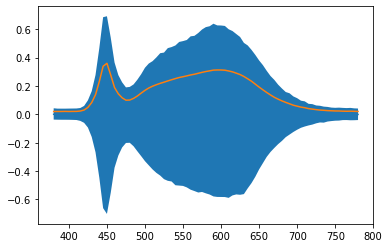

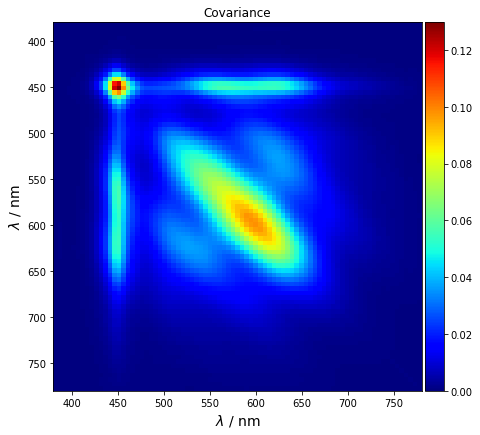

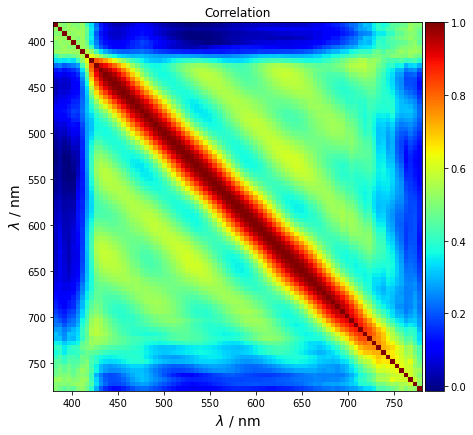

In [20]:
mcSpectrumSamples = MCSpectrumSamples(spd=spd_init, trials=trials)
mc_value = mc_enable.copy()
for key in mc_value:
    mc_value[key]=False
mc_value['value_noise_c']=True
mc_value['value_noise_nc']=True
mc_value['value_fourier_noise']=True
mc_value['all']=True

mcSpectrumSamples.run_MC(mc_value)
mcSpectrumSamples.calc_summary(wavelength_stat=False, scale_to_ref=True)

v_wl, v_mean, v_std, q_min, q_max, cov_image, corr_image, counts = mcSpectrumSamples.get_result()

pyplot.plot( v_wl, v_mean)
pyplot.plot( v_wl, v_std)
pyplot.fill_between( v_wl, q_min, q_max)

plotCorrelation( cov_image, v_wl, 'Covariance')

plotCorrelation( corr_image, v_wl, 'Correlation')

In [ ]:
XXX

f:\ttbv\python\empir19nrm02\venv\lib\site-packages\numpy\lib\function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


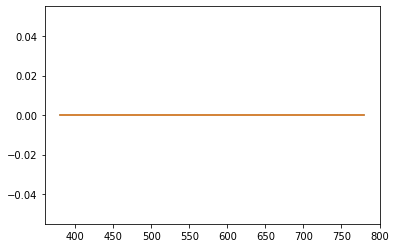

In [18]:
mcSpectrumSamples = MCSpectrumSamples(spd=spd_init, trials=trials)
mc_wl = mc_enable.copy()
for key in mc_wl:
    mc_wl[key]=False
mc_wl['wl_noise_c']=True
mc_wl['wl_noise_nc']=True
mc_wl['wl_fourier_noise']=True
mc_wl['all']=True

mcSpectrumSamples.run_MC(mc_wl)
mcSpectrumSamples.calc_summary(wavelength_stat=False, scale_to_ref=True)

v_wl, v_mean, v_std, q_min, q_max, cov_image, corr_image, counts = mcSpectrumSamples.get_result()

pyplot.plot( v_wl, v_mean)
pyplot.plot( v_wl, v_std)
pyplot.fill_between( v_wl, q_min, q_max)

def MC_simulation(mc_enable_loc, cov_matrix=None, former_results=None):

    print(mc_enable_loc)
    #mc_budget_table_array
    if former_results is None:
        mc_bta_loc = [mc_budget_table() for i in mc_enable_loc]
    else:
        mc_bta_loc = former_results

    McSpectrumInstance = MCSpectrumSamples(spd=spd_init, trials=trials)
    for iMC in mc_enable_loc:

        # initialise the result data arrays
        result1.fill(0)
        result3.fill(0)






        for i in range(0, trials):
            # calculate some sample integral data from the generated distribution

            [result1[0, i], _] = py_f1PrimeG(array_mc[i].spd.wl, array_mc[i].spd.value, strWeighting='A')
            [result1[1, i], _] = py_f1PrimeG(array_mc[i].spd.wl, array_mc[i].spd.value, strWeighting='E')
            [result1[2, i], _] = py_f1PrimeG(array_mc[i].spd.wl, array_mc[i].spd.value, strWeighting='LED_B3')
            [result1[3, i], _] = py_f1PrimeG(array_mc[i].spd.wl, array_mc[i].spd.value, strWeighting='A', iMin=True)
            [result1[4, i], _] = py_f1PrimeG(array_mc[i].spd.wl, array_mc[i].spd.value, strWeighting='E', dCutOff=-0.003)
            [result1[5, i], _] = py_f1PrimeG(array_mc[i].spd.wl, array_mc[i].spd.value, strWeighting='A', dBandWidth=20.)
            result3[0:3,i] = lx.xyz_to_Yxy(array_mc[i].spd.to_xyz(relative=False).value)
            result3[3,i] = lx.xyz_to_cct(array_mc[i].spd.to_xyz(relative=False).value)

        print("i=", iMC)

        if iMC=='cov'  and cov_matrix is not None:
                analyse = array2analyse(array_mc, wavelength_stat = False, scale_to_ref=scale_to_reference)
                print('Statistic with cov data')
                wl_data, spec_data, cov_image, corr_image = analyse_stat( array_mc, wavelength_stat = False, scale_to_ref=scale_to_reference, fontsize=label_font_size)
                save_fig(dir=out_dir, filename='MC_value_cov')
                res = np.vstack((wl_data, spec_data[0], spec_data[1]))
                np.savetxt(get_fig_file_name(dir=out_dir, filename='MC_value_Cov_spec', table=True), res, delimiter=';')
                np.savetxt(get_fig_file_name(dir=out_dir, filename='MC_value_Cov_cov', table=True), cov_image, delimiter=';')
                np.savetxt(get_fig_file_name(dir=out_dir, filename='MC_value_Cov_corr', table=True), corr_image, delimiter=';')
                plotHistScalesValue( analyse)

        if iMC=='all':
            # Show all the graphs only for the final result
            if mc_enable_loc['wl_noise_nc'] == True and mc_enable_loc['value_noise_nc'] == False:
                analyse = array2analyse(array_mc, wavelength_stat = True, scale_to_ref=scale_to_reference)
                print('Statistic for the wavelength scale')
                wl_data, spec_data, cov_image, corr_image = analyse_stat( array_mc, wavelength_stat = True, scale_to_ref=scale_to_reference, fontsize=label_font_size)
                res = np.vstack((wl_data, spec_data[0], spec_data[1]))
                np.savetxt(get_fig_file_name(dir=out_dir, filename='MC_wl_All_spec', table=True), res, delimiter=';')
                np.savetxt(get_fig_file_name(dir=out_dir, filename='MC_wl_All_cov', table=True), cov_image, delimiter=';')
                np.savetxt(get_fig_file_name(dir=out_dir, filename='MC_wl_All_corr', table=True), corr_image, delimiter=';')
                plotHistScalesWl( analyse)

            if mc_enable_loc['value_noise_nc'] == True and mc_enable_loc['wl_noise_nc'] == False :
                analyse = array2analyse(array_mc, wavelength_stat = False, scale_to_ref=scale_to_reference)
                print('Statistic for the value scale')
                wl_data, spec_data, cov_image, corr_image = analyse_stat( array_mc, wavelength_stat = False, scale_to_ref=scale_to_reference, fontsize=label_font_size)
                save_fig(dir=out_dir, filename='MC_value_All')
                res = np.vstack((wl_data, spec_data[0], spec_data[1]))
                np.savetxt(get_fig_file_name(dir=out_dir, filename='MC_value_All_spec', table=True), res, delimiter=';')
                np.savetxt(get_fig_file_name(dir=out_dir, filename='MC_value_All_cov', table=True), cov_image, delimiter=';')
                np.savetxt(get_fig_file_name(dir=out_dir, filename='MC_value_All_corr', table=True), corr_image, delimiter=';')
                plotHistScalesValue( analyse)

        # Calculate the sensitivity
        idx = list(mc_enable_loc.keys()).index(iMC)
        print('Store to idx:', idx)
        mc_bta_loc[idx].name = iMC
        erg=np.mean(result3, axis=1)
        mc_bta_loc[idx].Y=erg[0]
        mc_bta_loc[idx].x=erg[1]
        mc_bta_loc[idx].y=erg[2]
        mc_bta_loc[idx].cct=erg[3]
        serg=np.std(result3, axis=1)
        mc_bta_loc[idx].sY=serg[0]
        mc_bta_loc[idx].sx=serg[1]
        mc_bta_loc[idx].sy=serg[2]
        mc_bta_loc[idx].scct=serg[3]

        erg=np.mean(result1, axis=1)
        mc_bta_loc[idx].f1p=erg[0]
        mc_bta_loc[idx].f1pE=erg[1]
        mc_bta_loc[idx].f1pL=erg[2]
        mc_bta_loc[idx].f1pMin=erg[3]
        mc_bta_loc[idx].f1ppR=erg[4]
        mc_bta_loc[idx].f1pBW=erg[5]
        serg=np.std(result1, axis=1)
        mc_bta_loc[idx].sf1p=serg[0]
        mc_bta_loc[idx].sf1pE=serg[1]
        mc_bta_loc[idx].sf1pL=serg[2]
        mc_bta_loc[idx].sf1pMin=serg[3]
        mc_bta_loc[idx].sf1ppR=serg[4]
        mc_bta_loc[idx].sf1pBW=serg[5]
        if iMC!='all':
            mc_bta_loc[idx].mean = d_mean
            mc_bta_loc[idx].stddev = d_stddev
            mc_bta_loc[idx].dist = d_dist
            mc_bta_loc[idx].nb = d_nb
    return mc_bta_loc

# Simulation for the wavelength scale

In [13]:
mc_wl = mc_enable.copy()
for key in mc_wl:
    mc_wl[key]=False
mc_wl['wl_noise_c']=True
mc_wl['wl_noise_nc']=True
mc_wl['wl_fourier_noise']=True
mc_wl['all']=True

mc_bta=MC_simulation( mc_wl)

NameError: name 'MC_simulation' is not defined

# Simulation for the value scale

In [ ]:
mc_value = mc_enable.copy()
for key in mc_value:
    mc_value[key]=False
mc_value['value_noise_c']=True
mc_value['value_noise_nc']=True
mc_value['value_fourier_noise']=True
mc_value['all']=True

mc_bta=MC_simulation( mc_value)

# Simulation for the all together

In [ ]:
mc_all = mc_enable.copy()
mc_bta=MC_simulation( mc_all)

In [ ]:
cov_image_load = np.loadtxt(get_fig_file_name(dir=out_dir, filename='MC_value_All_cov', table=True), delimiter=';')

plotCorrelation( cov_image_load, array_mc[0].spd.wl, 'Covariance')


mc_cov = mc_enable.copy()
for key in mc_cov:
    mc_cov[key]=False

mc_cov['cov']=True
mc_bta=MC_simulation( mc_cov, cov_matrix=cov_image_load, former_results=mc_bta)


In [ ]:
eps=1e-6

def t_out( number, sigfigs=4):
    if abs(number)<eps:
        return round(str(number), decimals=sigfigs)
    else:
        return round(str(number), sigfigs=sigfigs)

import pyperclip
from prettytable import PrettyTable
from sigfig import round

x_table = PrettyTable()
x_table.field_names = ["Contribution", "Mean", "Std. Dev.", "NB", "Distribution",
                       "Y","x","y", "sY","sx","sy", "CCT", "sCCT",
                       "f1p","f1pE","f1pL","f1pMin","f1ppR","f1pBW","sf1p","sf1pE","sf1pL","sf1pMin","sf1ppR","sf1pBW"]

MCTable = pd.DataFrame()
for i in mc_enable:
    idx = list(mc_enable.keys()).index(i)
    if i == 'all':
        x_table.add_row([mc_bta[idx].name, '', '',
                         '', '',
                        t_out(mc_bta[idx].Y), t_out(mc_bta[idx].x), t_out(mc_bta[idx].y),
                        t_out(mc_bta[idx].sY, 2), t_out(mc_bta[idx].sx, 2), t_out(mc_bta[idx].sy, 2),
                        t_out(mc_bta[idx].cct), t_out(mc_bta[idx].scct, 2),
                        t_out(mc_bta[idx].f1p), t_out(mc_bta[idx].sf1p, 2),
                        t_out(mc_bta[idx].f1pE), t_out(mc_bta[idx].sf1pE, 2),
                        t_out(mc_bta[idx].f1pL), t_out(mc_bta[idx].sf1pL, 2),
                        t_out(mc_bta[idx].f1pMin), t_out(mc_bta[idx].sf1pMin, 2),
                        t_out(mc_bta[idx].f1ppR), t_out(mc_bta[idx].sf1ppR, 2),
                        t_out(mc_bta[idx].f1pBW), t_out(mc_bta[idx].sf1pBW, 2)])
    else:
        x_table.add_row([mc_bta[idx].name, mc_bta[idx].mean, mc_bta[idx].stddev,
                         mc_bta[idx].nb, mc_bta[idx].dist,
                        t_out(mc_bta[idx].Y), t_out(mc_bta[idx].x), t_out(mc_bta[idx].y),
                        t_out(mc_bta[idx].sY, 2), t_out(mc_bta[idx].sx, 2), t_out(mc_bta[idx].sy,2),
                        t_out(mc_bta[idx].cct), t_out(mc_bta[idx].scct, 2),
                        t_out(mc_bta[idx].f1p), t_out(mc_bta[idx].sf1p, 2),
                        t_out(mc_bta[idx].f1pE), t_out(mc_bta[idx].sf1pE, 2),
                        t_out(mc_bta[idx].f1pL), t_out(mc_bta[idx].sf1pL, 2),
                        t_out(mc_bta[idx].f1pMin), t_out(mc_bta[idx].sf1pMin, 2),
                        t_out(mc_bta[idx].f1ppR), t_out(mc_bta[idx].sf1ppR, 2),
                        t_out(mc_bta[idx].f1pBW), t_out(mc_bta[idx].sf1pBW, 2)])

    df = pd.DataFrame( { \
         'Contributon': [mc_bta[idx].name], \
         'Mean':mc_bta[idx].mean,
         'StdDev':mc_bta[idx].stddev,
         'NB':mc_bta[idx].nb,
         'Distribution':mc_bta[idx].dist,
         'Y':mc_bta[idx].Y,
         'x':mc_bta[idx].x,
         'y':mc_bta[idx].y,
         'cct':mc_bta[idx].cct,
         'sY':mc_bta[idx].sY,
         'sx':mc_bta[idx].sx,
         'sy':mc_bta[idx].sy,
         'scct':mc_bta[idx].scct,
         'f1p':mc_bta[idx].f1p,
         'sf1p':mc_bta[idx].sf1p,
         'f1pE':mc_bta[idx].f1pE,
         'sf1pE':mc_bta[idx].sf1pE,
         'f1pL':mc_bta[idx].f1pL,
         'sf1pL':mc_bta[idx].sf1pL,
         'f1pMin':mc_bta[idx].f1pMin,
         'sf1pMin':mc_bta[idx].sf1pMin,
         'f1ppR':mc_bta[idx].f1ppR,
         'sf1ppR':mc_bta[idx].sf1ppR,
         'f1pBW':mc_bta[idx].f1pBW,
         'sf1pBW':mc_bta[idx].sf1pBW,
          } )
    MCTable = pd.concat( [MCTable,df])

print(x_table)

MCTable
MCTable.to_csv(get_fig_file_name(dir=out_dir, filename='MCStandard', table=True), sep=';',  decimal=",")

In [ ]:
seaborn_plot_basedata(array_mc, wavelength_to_observe = 450)
seaborn_plot_basedata(array_mc, wavelength_to_observe = 550)
seaborn_plot_basedata(array_mc, wavelength_to_observe = 650)

In [ ]:
seaborn_plot_result( result3)

In [ ]:
def seaborn_plot_result_f1prime(loc_result):
    disp_array_count = loc_result.shape[1]
    #step=int(trials/200) + 1
    step=1
    disp_test = loc_result[0, 1::step]
    disp_array = np.zeros((6, disp_test.shape[0]))
    for i in range(6):
        disp_array[i] = loc_result[i, 1::step] - loc_result[i, 0]
    sns.set_theme(style="ticks")
    df = pd.DataFrame(data=disp_array.T,
                      columns=['$\Delta f_{1}^{´}$', '$\Delta f_{1,\mathrm{E}}^{´}$', '$\Delta f_{1,\mathrm{L}}^{´}$',
                               '$\Delta f_{1,\mathrm{Min}}^{´}$', '$\Delta f_{1,\mathrm{R}}^{´´}$', '$\Delta f_{1,\mathrm{BW=20nm}}^{´}$', ])
    grid = sns.pairplot(df, corner=True, kind="hist")

In [ ]:
seaborn_plot_result_f1prime( result1)
save_fig( dir=out_dir, filename='MCf1Results')

In [ ]:
def FourierTableP( trials, wl, SPD, uSPD):
    elements2Run = [0,1,2,3,4,5,6,7,8,9,10,20,30,40,42, 50,60,70,80,90,100,150,200,235]
    petriTable = pd.DataFrame()
    rMatrixSPD = np.zeros((trials, wl.shape[0]))
    start_data =np.r_[ wl.reshape(1,wl.shape[0]), SPD.reshape(1,wl.shape[0])]
    XYZ = lx.spd_to_xyz( start_data, relative=False, cieobs='1931_2')
    Yxy = lx.xyz_to_Yxy (XYZ)
    print( Yxy)
    x0 = Yxy[0,1]
    y0 = Yxy[0,2]
    L0 = Yxy[0,0]
    CCT0 = lx.xyz_to_cct(XYZ)[0,0]
    print( CCT0)
    for i, numberNew in enumerate(elements2Run):
        for j in range(trials):
            rMatrix=generate_FourierMC0( numberNew, wl, uSPD)
            rMatrixSPD[j] = (1+rMatrix)*SPD
        tmp_data =np.r_[ wl.reshape(1,wl.shape[0]), rMatrixSPD]
        XYZ = lx.spd_to_xyz( tmp_data, relative=False, cieobs='1931_2')
        Yxy = lx.xyz_to_Yxy (XYZ)
        xData = Yxy[:, 1]
        yData = Yxy[:, 2]
        L = Yxy[:, 0]
        CCT = lx.xyz_to_cct(XYZ)
        CCT.resize(trials)
        # Luminance
        [Lvalues, Linterval] = sumMC(L / L0, Coverage=0.95)
        #CCT
        [CCTvalues, CCTinterval] = sumMC(CCT, Coverage=0.95)
        #(x,y)
        [xvalues, xinterval] = sumMC(xData, Coverage=0.95)
        [yvalues, yinterval] = sumMC(yData, Coverage=0.95)
        df = pd.DataFrame( { \
            'N': [numberNew], \
            'dL_mean': Lvalues[0], 'L_std': Lvalues[1], 'L_95%': (Linterval[1]-Linterval[0])/2., \
            'dCCT_mean': (CCTvalues[0]-CCT0), 'CCT_std': CCTvalues[1], 'CCT_95%': (CCTinterval[1] - CCTinterval[0]) / 2., \
            'dx_mean': xvalues[0]-x0, 'x_std': xvalues[1], 'x_95%': (xinterval[1] - xinterval[0]) / 2., \
            'dy_mean': yvalues[0]-y0, 'y_std': yvalues[1], 'x_95%': (yinterval[1] - yinterval[0]) / 2., \
             } , dtype = 'float')

        petriTable = pd.concat( [petriTable, df])
        print( numberNew)
    return petriTable


def FourierTablef1p( trials, wl, SPD, uSPD):
    elements2Run = [0,1,2,3,4,5,6,7,8,9,10,20,30,40,42, 50,60,70,80,90,100,150,200,235]
    petriTable = pd.DataFrame()
    rMatrixSPD = np.zeros((trials, wl.shape[0]))

    start_data =np.r_[ wl.reshape(1,wl.shape[0]), SPD.reshape(1,wl.shape[0])]
    f1p0=py_f1PrimeGlx(start_data, strObserver='1931_2', iObserverOffset = 1, strWeighting='A', iMin=0, dCutOff=0., dBandWidth=0.)
    f1pE0=py_f1PrimeGlx(start_data, strObserver='1931_2', iObserverOffset = 1, strWeighting='E', iMin=0, dCutOff=0., dBandWidth=0.)
    f1pL0=py_f1PrimeGlx(start_data, strObserver='1931_2', iObserverOffset = 1, strWeighting='LED_B3', iMin=0, dCutOff=0., dBandWidth=0.)
    f1pMin0=py_f1PrimeGlx(start_data, strObserver='1931_2', iObserverOffset = 1, strWeighting='A', iMin=1, dCutOff=0., dBandWidth=0.)
    f1ppR0=py_f1PrimeGlx(start_data, strObserver='1931_2', iObserverOffset = 1, strWeighting='E', iMin=0, dCutOff=-0.003, dBandWidth=0.)
    f1pBW0=py_f1PrimeGlx(start_data, strObserver='1931_2', iObserverOffset = 1, strWeighting='A', iMin=0, dCutOff=0, dBandWidth=20.)
    for i, numberNew in enumerate(elements2Run):
        for j in range(trials):
            rMatrix=generate_FourierMC0( numberNew, wl, uSPD)
            rMatrixSPD[j] = (1+rMatrix)*SPD
        tmp_data =np.r_[ wl.reshape(1,wl.shape[0]), rMatrixSPD]
        f1p=py_f1PrimeGlx(tmp_data, strObserver='1931_2', iObserverOffset = 1, strWeighting='A', iMin=0, dCutOff=0., dBandWidth=0.)
        f1pE=py_f1PrimeGlx(tmp_data, strObserver='1931_2', iObserverOffset = 1, strWeighting='E', iMin=0, dCutOff=0., dBandWidth=0.)
        f1pL=py_f1PrimeGlx(tmp_data, strObserver='1931_2', iObserverOffset = 1, strWeighting='LED_B3', iMin=0, dCutOff=0., dBandWidth=0.)
        f1pMin=py_f1PrimeGlx(tmp_data, strObserver='1931_2', iObserverOffset = 1, strWeighting='A', iMin=1, dCutOff=0., dBandWidth=0.)
        f1ppR=py_f1PrimeGlx(tmp_data, strObserver='1931_2', iObserverOffset = 1, strWeighting='E', iMin=0, dCutOff=-0.003, dBandWidth=0.)
        f1pBW=py_f1PrimeGlx(tmp_data, strObserver='1931_2', iObserverOffset = 1, strWeighting='A', iMin=0, dCutOff=0, dBandWidth=20.)

        [f1p_values, f1p_interval] = sumMC(f1p, Coverage=0.95)
        [f1pE_values, f1pE_interval] = sumMC(f1pE, Coverage=0.95)
        [f1pL_values, f1pL_interval] = sumMC(f1pL, Coverage=0.95)
        [f1pMin_values, f1pMin_interval] = sumMC(f1pMin, Coverage=0.95)
        [f1ppR_values, f1ppR_interval] = sumMC(f1ppR, Coverage=0.95)
        [f1pBW_values, f1pBW_interval] = sumMC(f1pBW, Coverage=0.95)
        df = pd.DataFrame( { \
            'N': [numberNew], \
            'df1p': f1p_values[0]-f1p0, 'f1p_std': f1p_values[1], 'f1p_95%': (f1p_interval[1]-f1p_interval[0])/2., \
            'df1pE': f1pE_values[0]-f1pE0, 'f1pE_std': f1pE_values[1], 'f1pE_95%': (f1pE_interval[1]-f1pE_interval[0])/2., \
            'df1pL': f1pL_values[0]-f1pL0, 'f1pL_std': f1pL_values[1], 'f1pL_95%': (f1pL_interval[1]-f1pL_interval[0])/2., \
            'df1pMin': f1pMin_values[0]-f1pMin0, 'f1pMin_std': f1pMin_values[1], 'f1pMin_95%': (f1pMin_interval[1]-f1pMin_interval[0])/2., \
            'df1ppR': f1ppR_values[0]-f1ppR0, 'f1ppR_std': f1ppR_values[1], 'f1ppR_95%': (f1ppR_interval[1]-f1ppR_interval[0])/2., \
            'df1pBW': f1pBW_values[0]-f1pBW0, 'f1pBW_std': f1pBW_values[1], 'f1pBW_95%': (f1pBW_interval[1]-f1pBW_interval[0])/2., \
             } , dtype = 'float')
        petriTable = pd.concat([petriTable,df])
        print( numberNew)
    return petriTable

In [ ]:
res_VL = spd_init[0].shape[0]
uSPD=np.zeros(res_VL)
uSPD[:]=0.01

In [ ]:
print( 'FourierTableP')
petriTableP=FourierTableP(100, spd_init[0], spd_init[1], uSPD)
petriTableP
petriTableP.to_csv(get_fig_file_name(dir=out_dir, filename='FourierP', table=True), sep=';',  decimal=",")

In [ ]:
[f1pOrg, _]=py_f1PrimeG(spd_init[0], spd_init[1], strObserver='1931_2', iObserverOffset = 1, strWeighting='A', iMin=0, dCutOff=0., dBandWidth=0.)
print('f1pOrg=', f1pOrg)

print( 'FourierTablef1p')
petriTable=FourierTablef1p(100, spd_init[0], spd_init[1], uSPD)
petriTable
petriTable.to_csv(get_fig_file_name(dir=out_dir, filename='Fourierf1p', table=True), sep=';',  decimal=",")

In [ ]:
fig, ax1 = pyplot.subplots(figsize=(10,7))
petriTable.plot.scatter(x="N", y="df1p", marker='o', color="Red", label="$\Delta f_{1}^{´}$", ax=ax1)
petriTable.plot.scatter(x="N", y="df1pE", marker='x', color="Red", label="$\Delta f_{1,\mathrm{E}}^{´}$", ax=ax1)
petriTable.plot.scatter(x="N", y="df1pL", marker='1', color="Red", label="$\Delta f_{1,\mathrm{L}}^{´}$", ax=ax1)
petriTable.plot.scatter(x="N", y="df1pMin", marker='<', color="Red", label="$\Delta f_{1,\mathrm{Min}}^{´}$", ax=ax1)
petriTable.plot.scatter(x="N", y="df1ppR", marker='>', color="Blue", label="$\Delta f_{1,\mathrm{R}}^{´´}$", ax=ax1)
petriTable.plot.scatter(x="N", y="df1pBW", marker='2', color="Blue", label="$\Delta f_{1,\mathrm{BW}}^{´}$", ax=ax1)
ax1.set_xlabel('$N_{\mathrm{B}}$', fontsize=label_font_size)
ax1.set_ylabel('$\Delta f_{1}^{´}, \Delta f_{1,\mathrm{E}}^{´}, \Delta f_{1,\mathrm{L}}^{´},  \Delta f_{1,\mathrm{Min}}^{´}, \Delta f_{1,\mathrm{R}}^{´´}, \Delta f_{1,\mathrm{BW}}^{´} $', fontsize=label_font_size)
ax1.set_xlim([0,50])

save_fig(dir=out_dir, filename='f1pTableFourier')


In [ ]:
fig, ax1 = pyplot.subplots(figsize=(10,7))
petriTable.plot.scatter(x="N", y="f1p_95%", marker='o', color="Red", label="U($f_{1}^{´})$", ax=ax1)
petriTable.plot.scatter(x="N", y="f1pE_95%", marker='x', color="Red", label="U($f_{1, \mathrm{E}}^{´})$", ax=ax1)
petriTable.plot.scatter(x="N", y="f1pL_95%", marker='1', color="Red", label="$U(f_{1,\mathrm{L}}^{´})$", ax=ax1)
petriTable.plot.scatter(x="N", y="f1pMin_95%", marker='<', color="Red", label="U($f_{1, \mathrm{Min}}^{´})$", ax=ax1)
petriTable.plot.scatter(x="N", y="f1ppR_95%", marker='>', color="Blue", label="$U(f_{1,\mathrm{R}}^{´´})$", ax=ax1)
petriTable.plot.scatter(x="N", y="f1pBW_95%", marker='2', color="Blue", label="$U(f_{1,\mathrm{BW}}^{´})$", ax=ax1)
ax1.set_xlabel('$N_{\mathrm{B}}$', fontsize=label_font_size)
ax1.set_ylabel('$U(f_{1}^{´}), U(f_{1,\mathrm{E}}^{´}), U(f_{1,\mathrm{L}}^{´}),  U(f_{1,\mathrm{Min}}^{´}), U(f_{1,\mathrm{R}}^{´´}), U(f_{1,\mathrm{BW}}^{´})$', fontsize=label_font_size)
ax1.set_xlim([0,50])

save_fig(dir=out_dir, filename='Uf1pTableFourier')

In [ ]:
fig, ax1 = pyplot.subplots(figsize=(10,7))
#petriTableP.plot.scatter(x="N", y="dL_mean", marker='o', color="Red", label="$\Delta Y$", ax=ax1)
petriTableP.plot.scatter(x="N", y="dx_mean", marker='x', color="Red", label="$\Delta x$", ax=ax1)
petriTableP.plot.scatter(x="N", y="dy_mean", marker='1', color="Red", label="$\Delta y$", ax=ax1)
ax2 = ax1.twinx()
petriTableP.plot.scatter(x="N", y="dCCT_mean", marker='<', color="Red", label="$\Delta CCT$", ax=ax2)
ax1.set_xlabel('$N_{\mathrm{B}}$', fontsize=label_font_size)
ax1.set_ylabel('$\Delta Y, \Delta x, \Delta y, \Delta CCT $', fontsize=label_font_size)
ax1.set_xlim([0,50])

save_fig(dir=out_dir, filename='PTableFourier')


In [ ]:
fig, ax1 = pyplot.subplots(figsize=(10,7))
#petriTableP.plot.scatter(x="N", y="L_std", marker='o', color="Red", label="$u(Y)$", ax=ax1)
petriTableP.plot.scatter(x="N", y="x_std", marker='x', color="Red", label="$u(x)$", ax=ax1)
petriTableP.plot.scatter(x="N", y="y_std", marker='1', color="Red", label="$u(y)$", ax=ax1)
ax2 = ax1.twinx()
petriTableP.plot.scatter(x="N", y="CCT_std", marker='<', color="Red", label="$u(CCT)$", ax=ax2)

ax1.set_xlabel('$N_{\mathrm{B}}$', fontsize=label_font_size)
ax1.set_ylabel('$U(f_{1}^{´}), U(f_{1,\mathrm{E}}^{´}), U(f_{1,\mathrm{L}}^{´}),  U(f_{1,\mathrm{Min}}^{´}), U(f_{1,\mathrm{R}}^{´´}), U(f_{1,\mathrm{BW}}^{´})$', fontsize=label_font_size)
ax1.set_xlim([0,50])

save_fig(dir=out_dir, filename='UPTableFourier')
